In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<h1>Direct imaging: the planet around beta-Pictoris</h1>
    
In this example we take a look at data obtained with the [NACO](https://www.eso.org/sci/facilities/paranal/decommissioned/naco.html) instrument on the [Very Large Telescope (VLT)](https://www.eso.org/public/unitedkingdom/teles-instr/paranal-observatory/vlt/). This data was described in a paper by [Bonnefoy et al. (2013)](https://arxiv.org/abs/1302.1160); we will be looking at data taken at $4.78~\mu {\rm m}$ (known as the $M'$ band). We will follow the example of the [`pynpoint`](https://pynpoint.readthedocs.io/en/latest/index.html) package and look at the planet around beta-Pictoris.  

<h2>Angular Differential Imaging</h2>

The brightness contrast between star and planet is the main concern with direct imaging. In the lecture notes, we covered coronographs as a possible solution. In this notebook, we cover a different technique called Angular Differential Imaging ([Marois et al. 2006](https://arxiv.org/abs/astro-ph/0512335)). This is a technique that can be used to subtract the light from the central star to very high accuracy. The central star is a point source, and the response of the optics system to a point source is called the Point Spread Function (PSF).

<h3>Field rotation</h3>

When taking long exposures while tracking an object, the field of view will rotate during the exposure; this is called [field rotation](https://themcdonalds.net/richard/wp/astrophotography-field-rotation/). Normally, this is corrected for during an observation using a field derotator. However, when looking for faint objects around a bright star, turning the derotator off can be advantageous. Since the telescope now does not rotate, any feature in the image introduced by the optics of the telescope will not rotate and can therefore be more easily subtracted. 

<h3>Accurate Point Spread function</h3>

We now take **many** short observations during one night, so that field rotation can be ignored for a single exposure. Atmospheric turbulence as well as thermal effects are likely to change the PSF during the night, but we can use the large number of observations to track these changes and construct *very* accurate PSFs. These can then be subtracted from each observation.     

<h2>Original image set</h2>

Below is an image set of 263 observations of beta-Pictoris. The star is in the middle of each image and completely dominates: no planet in sight! You can move the slider to look at different images, and you will see subtle changes. These are all artificial, possibly caused by atmospheric turbulence. 

In [2]:
%%capture
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from pynpoint import Pypeline, \
                     Hdf5ReadingModule, \
                     PSFpreparationModule, \
                     PcaPsfSubtractionModule

pipeline1 = Pypeline(working_place_in='./',
                    input_place_in='./',
                    output_place_in='./')


module = Hdf5ReadingModule(name_in='read',
                           input_filename='data/betapic_naco_mp.hdf5',
                           input_dir=None,
                           tag_dictionary={'stack': 'stack'})

pipeline1.add_module(module)

pipeline1.run()

#print(pipeline.get_tags())
raw_data = pipeline1.get_data('stack')
pixscale = pipeline1.get_attribute('stack', 'PIXSCALE')

size = pixscale*raw_data.shape[-1]/2.


/Users/sjp/python/epad_2body/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IntSlider(value=0, continuous_update=False, description='Image index:', max=262)

Output()

<IPython.core.display.Javascript object>


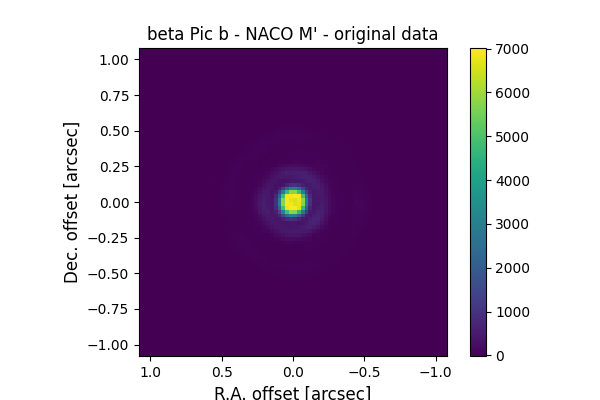

In [3]:
w_raw_index=widgets.IntSlider(
    value=0,
    min=0,
    max=262,
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

# Display button
output = widgets.Output()
display(w_raw_index, output)

fig1 = plt.figure(figsize=(6,4),num='Raw data')
ax1 = plt.gca()

im=ax1.imshow(raw_data[260, ], origin='lower', extent=[size, -size, -size, size])
ax1.set_title('beta Pic b - NACO M\' - original data')
ax1.set_xlabel('R.A. offset [arcsec]', fontsize=12)
ax1.set_ylabel('Dec. offset [arcsec]', fontsize=12)
plt.colorbar(im);

def on_value_change(change):
    with output:
        im.set_data(raw_data[w_raw_index.value])

        #ax3.set_title(name)
        #ax1.relim()
        #ax1.autoscale()

w_raw_index.observe(on_value_change, names='value')

<h2>Subtracting the saturated centre</h2>

The exposure time was chosen so that the central pixels are completely saturated. If we mask these out, the changes from frame to frame become much more apparent. You can now clearly see the ringed structure of the PSF (normal for circular apertures). Still no planet to be seen...

In [4]:
%%capture
pipeline2 = Pypeline(working_place_in='./',
                     input_place_in='./',
                     output_place_in='./')


module = Hdf5ReadingModule(name_in='read',
                           input_filename='data/betapic_naco_mp.hdf5',
                           input_dir=None,
                           tag_dictionary={'stack': 'stack'})

pipeline2.add_module(module)

module = PSFpreparationModule(name_in='prep',
                              image_in_tag='stack',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              resize=None,
                              cent_size=0.15,
                              edge_size=1.1)

pipeline2.add_module(module)

pipeline2.run()

psf_prep = pipeline2.get_data('prep')
pixscale = pipeline2.get_attribute('stack', 'PIXSCALE')

size = pixscale*psf_prep.shape[-1]/2.

/Users/sjp/python/epad_2body/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/sjp/python/epad_2body/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IntSlider(value=0, continuous_update=False, description='Image index:', max=262)

Output()

<IPython.core.display.Javascript object>


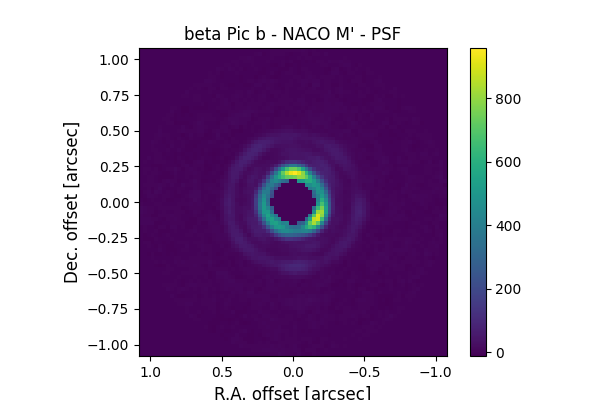

In [5]:
w_psf_index=widgets.IntSlider(
    value=0,
    min=0,
    max=262,
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

# Display button
output = widgets.Output()
display(w_psf_index, output)

fig2 = plt.figure(figsize=(6,4),num='PSF')
ax2 = plt.gca()

im2=ax2.imshow(psf_prep[0, ], origin='lower', extent=[size, -size, -size, size])
ax2.set_title('beta Pic b - NACO M\' - PSF')
ax2.set_xlabel('R.A. offset [arcsec]', fontsize=12)
ax2.set_ylabel('Dec. offset [arcsec]', fontsize=12)
plt.colorbar(im2);

def on_value_change(change):
    with output:
        im2.set_data(psf_prep[w_psf_index.value,])

        #ax3.set_title(name)
        #ax1.relim()
        #ax1.autoscale()

w_psf_index.observe(on_value_change, names='value')

<h2>Calculating and subtracting the PSF</h2>

The PSF is fitted using Principle Component Analysis. It takes the global shapes of the PSF and its variation with time to obtain a very accurate representation of the PSF that can then be subtracted. You can see in the individual images that the algorithm did a good job: there is nothing left but noise! The exposure times for the individual frames are too short to reveal the planet.  

In [6]:
%%capture
pipeline3 = Pypeline(working_place_in='./',
                     input_place_in='./',
                     output_place_in='./')


module = Hdf5ReadingModule(name_in='read',
                           input_filename='data/betapic_naco_mp.hdf5',
                           input_dir=None,
                           tag_dictionary={'stack': 'stack'})

pipeline3.add_module(module)

module = PSFpreparationModule(name_in='prep',
                              image_in_tag='stack',
                              image_out_tag='prep',
                              mask_out_tag=None,
                              norm=False,
                              resize=None,
                              cent_size=0.15,
                              edge_size=1.1)

pipeline3.add_module(module)

module = PcaPsfSubtractionModule(pca_numbers=[20, ],
                                 name_in='pca',
                                 images_in_tag='prep',
                                 reference_in_tag='prep',
                                 res_median_tag='residuals',
                                 res_arr_out_tag='res_array')

pipeline3.add_module(module)

pipeline3.run()

res_array = pipeline3.get_data('res_array20')
res_median = pipeline3.get_data('residuals')
pixscale = pipeline3.get_attribute('stack', 'PIXSCALE')

size = pixscale*res_median.shape[-1]/2.

/Users/sjp/python/epad_2body/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/sjp/python/epad_2body/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IntSlider(value=0, continuous_update=False, description='Image index:', max=262)

Output()

<IPython.core.display.Javascript object>


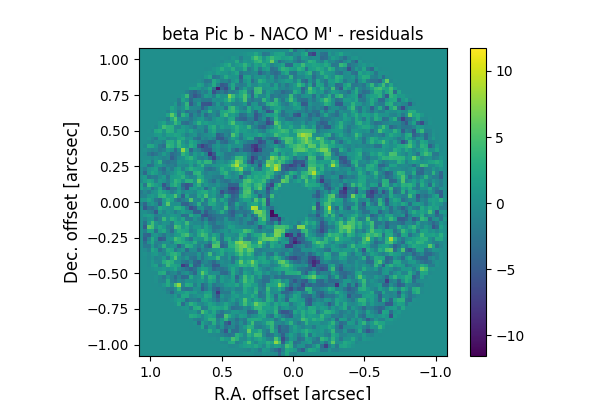

<IPython.core.display.Javascript object>


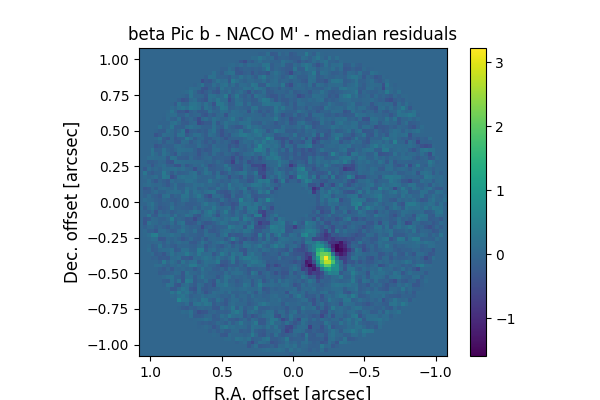

In [11]:
w_res_index=widgets.IntSlider(
    value=0,
    min=0,
    max=262,
    step=1,
    description='Image index:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

# Display button
output = widgets.Output()
display(w_res_index, output)

fig3 = plt.figure(figsize=(6,4),num='Residuals')
ax3 = plt.gca()

im3=ax3.imshow(res_array[0, ], origin='lower', extent=[size, -size, -size, size])
ax3.set_title('beta Pic b - NACO M\' - residuals')
ax3.set_xlabel('R.A. offset [arcsec]', fontsize=12)
ax3.set_ylabel('Dec. offset [arcsec]', fontsize=12)
plt.colorbar(im3);

fig4 = plt.figure(figsize=(6,4),num='Median Residuals')
ax4 = plt.gca()

im4=ax4.imshow(res_median[0, ], origin='lower', extent=[size, -size, -size, size])
ax4.set_title('beta Pic b - NACO M\' - median residuals')
ax4.set_xlabel('R.A. offset [arcsec]', fontsize=12)
ax4.set_ylabel('Dec. offset [arcsec]', fontsize=12)
plt.colorbar(im4);

def on_value_change(change):
    with output:
        im3.set_data(res_array[w_res_index.value,])

w_res_index.observe(on_value_change, names='value')

<h2>Combining all frames</h2>

If we now combine all frames, we can finally see the planet! The projected separation is roughly 0.5 arcseconds. As it turns out, this technique is much more powerful than taking a single, very long exposure. This would mean only a single, average PSF can be obtained, which is much less accurate. Another drawback is that a longer exposure time would mean much more of the image would get saturated, possibly flooding the planet as well (the brightness contrast strikes again!).  